In [ ]:
# %% ======================= CELL 1: LIBRARY (run once) =======================
# FT-Transformer for tabular/time-series — reusable library
# - Tracks train/val Loss & Macro-F1 per epoch
# - Balanced sampling + class-weighted CrossEntropy
# - OneCycleLR per-batch stepping
# - Threshold tuning utilities + confusion matrix
# - Clean separation so you can call it for many datasets

import math
import numpy as np
import pandas as pd
from typing import List, Dict, Optional, Tuple

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader, WeightedRandomSampler
from sklearn.preprocessing import StandardScaler
from sklearn.utils.class_weight import compute_class_weight
from sklearn.metrics import f1_score, classification_report, confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt


# --------------------------- Defaults ---------------------------
CFG_DEFAULT = dict(
    d_token=256,
    n_heads=8,
    n_layers=6,
    attn_dropout=0.15,
    ff_dropout=0.30,
    token_dropout=0.30,
    mlp_hidden=[512, 256, 128],
    mlp_dropout=0.35,

    batch_size=256,
    lr=3e-4,
    weight_decay=2e-3,
    epochs=300,
    early_stopping_patience=40,

    seed=42,
    num_workers=0,
    device="cuda" if torch.cuda.is_available() else "cpu",
    grad_clip_norm=1.0,   # set None to disable
)


# --------------------------- Utils ---------------------------
def set_seed(seed: int):
    import random, os
    random.seed(seed); np.random.seed(seed)
    torch.manual_seed(seed); torch.cuda.manual_seed_all(seed)
    os.environ["PYTHONHASHSEED"] = str(seed)


def make_multiclass_target(df: pd.DataFrame, label_cols: List[str], target_col='target') -> pd.DataFrame:
    """Turn one-hot label columns into a single int target."""
    labels_matrix = df[label_cols].astype(float).values
    df[target_col] = labels_matrix.argmax(axis=1)
    return df


def build_scaler(df_train: pd.DataFrame, cont_cols: List[str]) -> Optional[StandardScaler]:
    scaler = StandardScaler()
    if cont_cols:
        scaler.fit(df_train[cont_cols].astype(float).values)
    return scaler


def infer_cardinalities(df: pd.DataFrame, cat_cols: List[str]) -> List[int]:
    return [int(df[c].max()) + 1 for c in cat_cols] if cat_cols else []


def split_train_val(df: pd.DataFrame, y_int: np.ndarray, group_col: Optional[str] = 'cow',
                    train_size: float = 0.8, seed: int = 42) -> Tuple[np.ndarray, np.ndarray]:
    """Group-aware split on 'cow' if present, else stratified."""
    from sklearn.model_selection import GroupShuffleSplit, StratifiedShuffleSplit
    if group_col and group_col in df.columns:
        gss = GroupShuffleSplit(n_splits=1, train_size=train_size, random_state=seed)
        groups = df[group_col]
        tr_idx, va_idx = next(gss.split(df, y_int, groups))
    else:
        sss = StratifiedShuffleSplit(n_splits=1, train_size=train_size, random_state=seed)
        tr_idx, va_idx = next(sss.split(df, y_int))
    return tr_idx, va_idx


def build_feature_lists(df: pd.DataFrame, label_cols: List[str], drop_cols: List[str], target_col='target'):
    excluded = set(label_cols + drop_cols + [target_col])
    candidate = [c for c in df.columns if c not in excluded]
    cont_cols = [c for c in candidate if np.issubdtype(df[c].dtype, np.number)]
    cat_cols  = []  # fill with integer-encoded categorical col names if you have them
    if len(cont_cols) + len(cat_cols) == 0:
        raise ValueError("No features found. Check your drop/feature lists and dtypes.")
    return cont_cols, cat_cols


# --------------------------- Dataset ---------------------------
class TabularDataset(Dataset):
    def __init__(self, df: pd.DataFrame, cont_cols: List[str], cat_cols: List[str],
                 label_col: Optional[str] = None, scaler: Optional[StandardScaler] = None):
        self.df = df.reset_index(drop=True)
        self.cont_cols = cont_cols
        self.cat_cols = cat_cols
        self.label_col = label_col

        cont = df[cont_cols].astype(float).values if cont_cols else np.zeros((len(df), 0), dtype=np.float32)
        if scaler is not None and cont.shape[1] > 0:
            cont = scaler.transform(cont)
        self.cont = cont.astype(np.float32)

        if cat_cols:
            cats = [df[c].astype(int).values for c in cat_cols]
            self.cats = np.stack(cats, axis=1).astype(np.int64)
        else:
            self.cats = np.zeros((len(df), 0), dtype=np.int64)

        self.y = df[label_col].astype(int).values if label_col is not None else None

    def __len__(self): return len(self.df)

    def __getitem__(self, idx):
        x_cont = torch.from_numpy(self.cont[idx]) if self.cont.shape[1] > 0 else torch.zeros(0)
        x_cat  = torch.from_numpy(self.cats[idx]) if self.cats.shape[1] > 0 else torch.zeros(0, dtype=torch.long)
        if self.y is None:
            return x_cont, x_cat
        return x_cont, x_cat, torch.tensor(self.y[idx], dtype=torch.long)


# --------------------------- FT-Transformer ---------------------------
class FeatureTokenizer(nn.Module):
    def __init__(self, n_cont: int, cat_cardinalities: List[int], d_token: int):
        super().__init__()
        self.n_cont = n_cont
        self.n_cat = len(cat_cardinalities)
        self.d_token = d_token

        self.cls = nn.Parameter(torch.zeros(1, 1, d_token))
        nn.init.trunc_normal_(self.cls, std=0.02)

        self.cat_embeds = nn.ModuleList([nn.Embedding(card, d_token) for card in cat_cardinalities])
        for emb in self.cat_embeds:
            nn.init.trunc_normal_((emb.weight), std=0.02)

        self.cont_linears = nn.ModuleList([nn.Linear(1, d_token) for _ in range(n_cont)])
        self.cont_norm = nn.LayerNorm(d_token)

    def forward(self, x_cont: torch.Tensor, x_cat: torch.Tensor) -> torch.Tensor:
        B = x_cont.size(0) if x_cont.ndim == 2 else x_cat.size(0)
        tokens = [self.cls.expand(B, -1, -1)]  # [B, 1, d]

        if self.n_cat > 0:
            cat_tokens = torch.stack([emb(x_cat[:, i]) for i, emb in enumerate(self.cat_embeds)], dim=1)
            tokens.append(cat_tokens)  # [B, n_cat, d]

        if self.n_cont > 0:
            cont_tokens = []
            for i, lin in enumerate(self.cont_linears):
                v = self.cont_norm(lin(x_cont[:, i:i+1]))  # [B, d]
                cont_tokens.append(v)
            cont_tokens = torch.stack(cont_tokens, dim=1)  # [B, n_cont, d]
            tokens.append(cont_tokens)

        return torch.cat(tokens, dim=1)  # [B, L, d]


class TokenDropout(nn.Module):
    def __init__(self, p: float): super().__init__(); self.p = p
    def forward(self, x: torch.Tensor) -> torch.Tensor:
        if not self.training or self.p <= 0.0: return x
        B, L, D = x.shape
        mask = torch.ones(B, L, device=x.device, dtype=torch.bool)
        drop = torch.rand(B, L-1, device=x.device) < self.p
        mask[:, 1:] = ~drop  # keep CLS
        return x * mask.unsqueeze(-1)


class FTTransformer(nn.Module):
    def __init__(self, n_cont: int, cat_cardinalities: List[int], d_token: int,
                 n_heads: int, n_layers: int, attn_dropout: float, ff_dropout: float,
                 token_dropout: float, num_classes: int, mlp_hidden: List[int], mlp_dropout: float):
        super().__init__()
        self.tokenizer = FeatureTokenizer(n_cont, cat_cardinalities, d_token)
        self.token_dropout = TokenDropout(token_dropout)

        encoder_layer = nn.TransformerEncoderLayer(
            d_model=d_token, nhead=n_heads, dim_feedforward=d_token * 4,
            dropout=ff_dropout, batch_first=True, activation="gelu"
        )
        self.encoder = nn.TransformerEncoder(encoder_layer, num_layers=n_layers)

        layers, in_dim = [], d_token
        for h in mlp_hidden:
            layers += [nn.Linear(in_dim, h), nn.ReLU(), nn.Dropout(mlp_dropout)]
            in_dim = h
        layers += [nn.Linear(in_dim, num_classes)]
        self.head = nn.Sequential(*layers)

        for m in self.head:
            if isinstance(m, nn.Linear):
                nn.init.xavier_uniform_(m.weight); nn.init.zeros_(m.bias) if m.bias is not None else None

    def forward(self, x_cont: torch.Tensor, x_cat: torch.Tensor) -> torch.Tensor:
        x = self.tokenizer(x_cont, x_cat)
        x = self.token_dropout(x)
        x = self.encoder(x)
        cls = x[:, 0, :]
        return self.head(cls)


# --------------------------- Train / Eval ---------------------------
def train_one_epoch(model, loader, optimizer, criterion, device, scheduler=None, grad_clip_norm: Optional[float]=None):
    model.train()
    run_loss, all_pred, all_true = 0.0, [], []
    for x_cont, x_cat, y in loader:
        x_cont, x_cat, y = x_cont.to(device), x_cat.to(device), y.to(device)
        optimizer.zero_grad()
        logits = model(x_cont, x_cat)
        loss = criterion(logits, y)
        loss.backward()
        if grad_clip_norm: nn.utils.clip_grad_norm_(model.parameters(), grad_clip_norm)
        optimizer.step()
        if scheduler is not None: scheduler.step()

        run_loss += loss.item() * y.size(0)
        all_pred.append(logits.argmax(1).detach().cpu()); all_true.append(y.detach().cpu())

    y_true = torch.cat(all_true).numpy(); y_pred = torch.cat(all_pred).numpy()
    return run_loss / len(loader.dataset), f1_score(y_true, y_pred, average='macro')


@torch.no_grad()
def evaluate(model, loader, criterion, device):
    model.eval()
    run_loss, logits_all, y_all = 0.0, [], []
    for x_cont, x_cat, y in loader:
        x_cont, x_cat, y = x_cont.to(device), x_cat.to(device), y.to(device)
        logits = model(x_cont, x_cat)
        loss = criterion(logits, y)
        run_loss += loss.item() * y.size(0)
        logits_all.append(logits.cpu()); y_all.append(y.cpu())
    logits = torch.cat(logits_all, 0)
    y_true = torch.cat(y_all).numpy()
    y_pred = logits.argmax(1).numpy()
    return run_loss / len(loader.dataset), f1_score(y_true, y_pred, average='macro'), (y_true, y_pred), logits.numpy()


def fit(model, train_loader, val_loader, optimizer, scheduler, criterion, device,
        epochs: int, patience: int, grad_clip_norm: Optional[float] = None):
    best_val_f1, best_state, patience_ctr = -1.0, None, 0
    history = {"train_loss": [], "train_f1": [], "val_loss": [], "val_f1": [], "best_epoch": None}

    for epoch in range(1, epochs + 1):
        tr_loss, tr_f1 = train_one_epoch(model, train_loader, optimizer, criterion, device,
                                         scheduler=scheduler, grad_clip_norm=grad_clip_norm)
        va_loss, va_f1, _, _ = evaluate(model, val_loader, criterion, device)

        history["train_loss"].append(tr_loss); history["train_f1"].append(tr_f1)
        history["val_loss"].append(va_loss);   history["val_f1"].append(va_f1)

        print(f"Epoch {epoch:03d} | train_loss={tr_loss:.4f} f1={tr_f1:.4f} | val_loss={va_loss:.4f} f1={va_f1:.4f}")

        if va_f1 > best_val_f1:
            best_val_f1, patience_ctr, history["best_epoch"] = va_f1, 0, epoch
            best_state = {k: v.cpu().clone() for k, v in model.state_dict().items()}
        else:
            patience_ctr += 1
            if patience_ctr >= patience:
                print(f"Early stopping at epoch {epoch}. Best val F1 @ {history['best_epoch']}: {best_val_f1:.4f}")
                break

    if best_state is not None:
        model.load_state_dict({k: v.to(device) for k, v in best_state.items()})
    return model, best_val_f1, history


# --------------------------- Threshold tuning & plots ---------------------------
def find_opt_thresholds(probs: np.ndarray, y_true: np.ndarray, search=np.linspace(0.2, 0.9, 36)) -> np.ndarray:
    C = probs.shape[1]
    best = np.zeros(C)
    for c in range(C):
        best_f1, best_t = -1.0, 0.5
        y_c = (y_true == c).astype(int)
        for t in search:
            pred_c = (probs[:, c] >= t).astype(int)
            f1 = f1_score(y_c, pred_c, zero_division=0)
            if f1 > best_f1: best_f1, best_t = f1, t
        best[c] = best_t
    return best


@torch.no_grad()
def collect_probs_and_true(model, loader, device):
    model.eval()
    P, Y = [], []
    for x_cont, x_cat, y in loader:
        x_cont, x_cat = x_cont.to(device), x_cat.to(device)
        logits = model(x_cont, x_cat)
        P.append(torch.softmax(logits, 1).cpu().numpy())
        Y.append(y.numpy())
    return np.vstack(P), np.concatenate(Y)


def predict_with_thresholds(model, loader, thresholds, device):
    probs, y_true = collect_probs_and_true(model, loader, device)
    adj = (probs >= thresholds.reshape(1, -1)).astype(int)
    preds = np.where(adj.sum(1) > 0, adj.argmax(1), probs.argmax(1))
    return preds, y_true, probs


def evaluate_with_cm(y_true, y_pred, labels_names, title):
    print(f"\n{title}:")
    print(classification_report(y_true, y_pred, target_names=labels_names, digits=4))
    print(f"Macro F1: {f1_score(y_true, y_pred, average='macro'):.4f}   "
          f"Weighted F1: {f1_score(y_true, y_pred, average='weighted'):.4f}")
    cm = confusion_matrix(y_true, y_pred)
    fig, ax = plt.subplots(figsize=(10, 10))
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=labels_names)
    disp.plot(ax=ax, cmap=plt.cm.Blues)
    plt.title(f"{title} - Confusion Matrix")
    plt.show()


def plot_history(history: Dict[str, List[float]], title_prefix: str = "FT-Transformer", save_path_prefix: Optional[str] = None):
    epochs_ran = range(1, len(history["train_loss"]) + 1)

    plt.figure(figsize=(8, 5))
    plt.plot(epochs_ran, history["train_loss"], label="Train Loss")
    plt.plot(epochs_ran, history["val_loss"], label="Val Loss")
    if history.get("best_epoch"): plt.axvline(history["best_epoch"], ls="--", alpha=0.6, label=f"Best Epoch = {history['best_epoch']}")
    plt.xlabel("Epoch"); plt.ylabel("Loss"); plt.title(f"{title_prefix} — Loss over Epochs")
    plt.legend(); plt.grid(True)
    if save_path_prefix: plt.savefig(f"{save_path_prefix}_loss.png", bbox_inches="tight", dpi=150)
    plt.show()

    plt.figure(figsize=(8, 5))
    plt.plot(epochs_ran, history["train_f1"], label="Train Macro-F1")
    plt.plot(epochs_ran, history["val_f1"], label="Val Macro-F1")
    if history.get("best_epoch"): plt.axvline(history["best_epoch"], ls="--", alpha=0.6, label=f"Best Epoch = {history['best_epoch']}")
    plt.xlabel("Epoch"); plt.ylabel("Macro-F1"); plt.title(f"{title_prefix} — Macro-F1 over Epochs")
    plt.legend(); plt.grid(True)
    if save_path_prefix: plt.savefig(f"{save_path_prefix}_f1.png", bbox_inches="tight", dpi=150)
    plt.show()


# --------------------------- High-level runner ---------------------------
def run_ft_transformer(df_train: pd.DataFrame, df_val: pd.DataFrame,
                       cont_cols: List[str], cat_cols: List[str],
                       label_col: str, num_classes: int, cfg: Dict) -> Tuple[nn.Module, StandardScaler, Dict]:
    """End-to-end: dataloaders, model, optimizer/scheduler, fit, return history."""
    cfg_full = {**CFG_DEFAULT, **(cfg or {})}
    set_seed(cfg_full["seed"]); device = cfg_full["device"]

    scaler = build_scaler(df_train, cont_cols)

    ds_train = TabularDataset(df_train, cont_cols, cat_cols, label_col, scaler)
    ds_val   = TabularDataset(df_val,   cont_cols, cat_cols, label_col, scaler)

    # Class weights & balanced sampler
    y_train = df_train[label_col].astype(int).values
    classes = np.arange(num_classes)
    cw = compute_class_weight(class_weight="balanced", classes=classes, y=y_train)
    criterion = nn.CrossEntropyLoss(weight=torch.tensor(cw, dtype=torch.float32, device=device))

    class_counts = np.array([(y_train == c).sum() for c in classes])
    sw = (1.0 / (class_counts + 1e-9))[y_train].astype(np.float64)
    sampler = WeightedRandomSampler(weights=torch.from_numpy(sw), num_samples=len(sw), replacement=True)

    train_loader = DataLoader(ds_train, batch_size=cfg_full["batch_size"], sampler=sampler,
                              num_workers=cfg_full["num_workers"], pin_memory=True)
    val_loader   = DataLoader(ds_val, batch_size=cfg_full["batch_size"], shuffle=False,
                              num_workers=cfg_full["num_workers"], pin_memory=True)

    # Model
    cat_cards = infer_cardinalities(df_train, cat_cols)
    model = FTTransformer(
        n_cont=len(cont_cols), cat_cardinalities=cat_cards, d_token=cfg_full["d_token"],
        n_heads=cfg_full["n_heads"], n_layers=cfg_full["n_layers"],
        attn_dropout=cfg_full["attn_dropout"], ff_dropout=cfg_full["ff_dropout"],
        token_dropout=cfg_full["token_dropout"], num_classes=num_classes,
        mlp_hidden=cfg_full["mlp_hidden"], mlp_dropout=cfg_full["mlp_dropout"]
    ).to(device)

    # Optim & OneCycleLR
    optimizer = torch.optim.AdamW(model.parameters(), lr=cfg_full["lr"], weight_decay=cfg_full["weight_decay"])
    steps_per_epoch = max(1, len(train_loader))
    scheduler = torch.optim.lr_scheduler.OneCycleLR(
        optimizer, max_lr=cfg_full["lr"], steps_per_epoch=steps_per_epoch,
        epochs=cfg_full["epochs"], pct_start=0.1, div_factor=10, final_div_factor=10
    )

    # Fit
    model, best_val_f1, history = fit(
        model, train_loader, val_loader, optimizer, scheduler, criterion, device,
        epochs=cfg_full["epochs"], patience=cfg_full["early_stopping_patience"],
        grad_clip_norm=cfg_full.get("grad_clip_norm", None)
    )

    # quick argmax val report
    _, _, (y_true, y_pred), _ = evaluate(model, val_loader, criterion, device)
    print("\nValidation classification report (argmax):")
    print(classification_report(y_true, y_pred, digits=4))

    return model, scaler, history


Epoch 001 | train_loss=1.6532 f1=0.2732 | val_loss=1.6450 f1=0.2114
Epoch 002 | train_loss=1.4358 f1=0.3685 | val_loss=1.7792 f1=0.2332
Epoch 003 | train_loss=1.3363 f1=0.4074 | val_loss=1.6961 f1=0.3193
Epoch 004 | train_loss=1.2250 f1=0.4600 | val_loss=1.7871 f1=0.3259
Epoch 005 | train_loss=1.1330 f1=0.5151 | val_loss=1.7918 f1=0.3245
Epoch 006 | train_loss=1.0464 f1=0.5562 | val_loss=1.9221 f1=0.3374
Epoch 007 | train_loss=0.9583 f1=0.5967 | val_loss=2.1064 f1=0.3155
Epoch 008 | train_loss=0.8789 f1=0.6315 | val_loss=2.2074 f1=0.3066
Epoch 009 | train_loss=0.8161 f1=0.6632 | val_loss=2.3015 f1=0.3486
Epoch 010 | train_loss=0.7637 f1=0.6840 | val_loss=2.3949 f1=0.3433
Epoch 011 | train_loss=0.7180 f1=0.7067 | val_loss=2.5607 f1=0.3412
Epoch 012 | train_loss=0.6751 f1=0.7216 | val_loss=2.4366 f1=0.3862
Epoch 013 | train_loss=0.6427 f1=0.7378 | val_loss=2.8541 f1=0.3858
Epoch 014 | train_loss=0.6045 f1=0.7558 | val_loss=2.5059 f1=0.4071
Epoch 015 | train_loss=0.5679 f1=0.7734 | val_lo

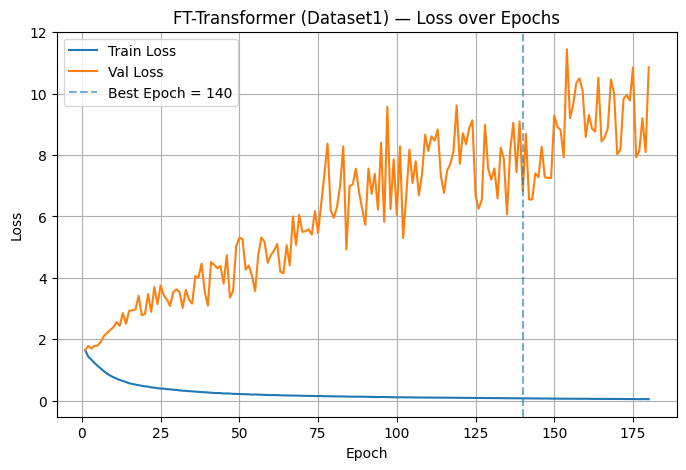

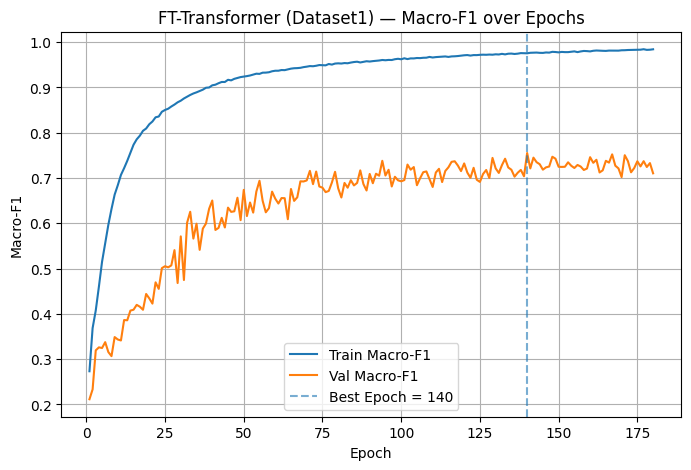


Dataset1 — Validation (thresholded):
               precision    recall  f1-score   support

      oestrus     0.8084    0.8626    0.8346      5042
      calving     0.8867    0.9968    0.9385       620
     lameness     0.9535    0.3586    0.5212      8853
     mastitis     0.9666    0.8271    0.8914      3360
other_disease     0.7569    0.9871    0.8568       388
           OK     0.3906    0.8479    0.5348      4676

     accuracy                         0.6656     22939
    macro avg     0.7938    0.8134    0.7629     22939
 weighted avg     0.8036    0.6656    0.6641     22939

Macro F1: 0.7629   Weighted F1: 0.6641


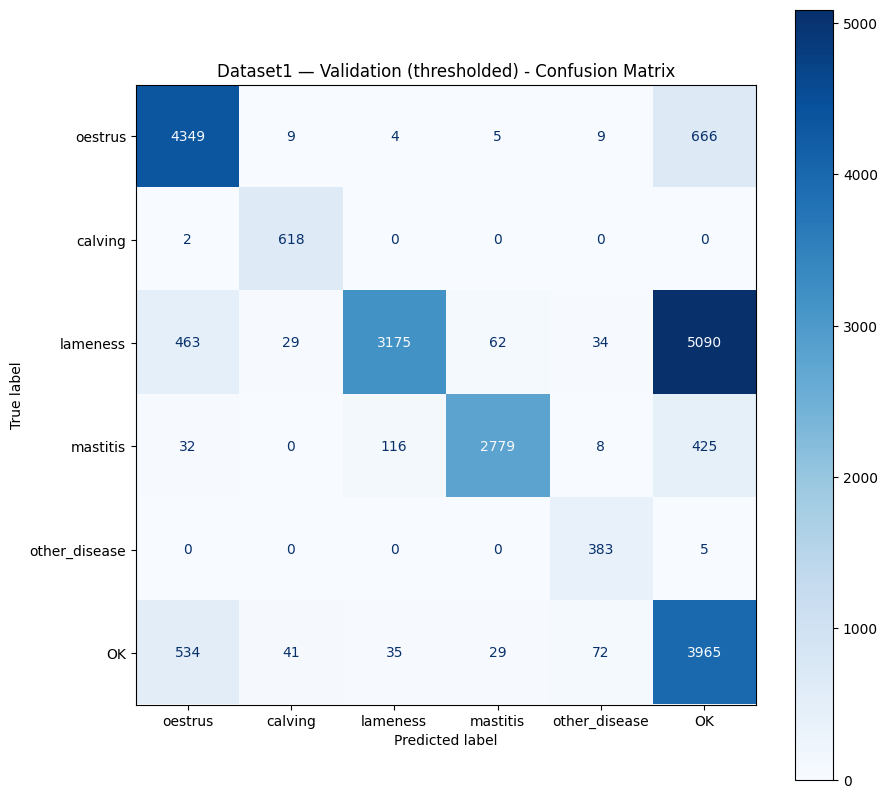


Dataset1 — Test (argmax):
               precision    recall  f1-score   support

      oestrus     0.9056    0.9500    0.9273      2000
      calving     0.9933    1.0000    0.9966      2072
     lameness     0.9856    0.6959    0.8158      2072
     mastitis     0.9896    0.9648    0.9770      2071
other_disease     0.9833    0.9995    0.9913      2063
           OK     0.6892    0.8883    0.7762      1782

     accuracy                         0.9168     12060
    macro avg     0.9244    0.9164    0.9140     12060
 weighted avg     0.9302    0.9168    0.9172     12060

Macro F1: 0.9140   Weighted F1: 0.9172


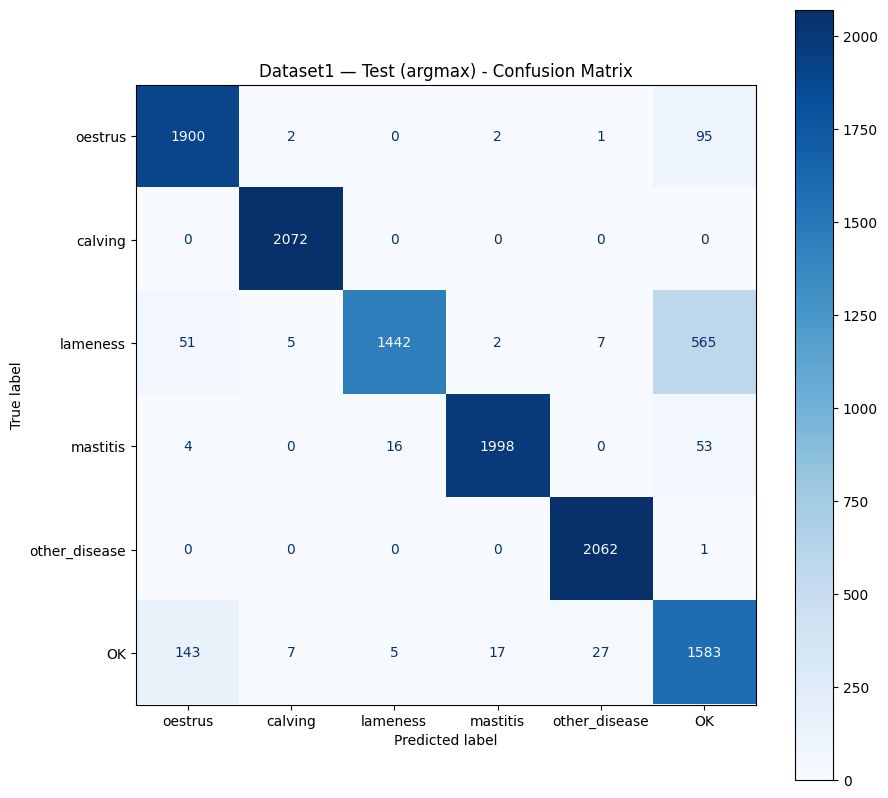


Dataset1 — Test (thresholded):
               precision    recall  f1-score   support

      oestrus     0.9056    0.9500    0.9273      2000
      calving     0.9933    1.0000    0.9966      2072
     lameness     0.9837    0.7003    0.8182      2072
     mastitis     0.9892    0.9710    0.9800      2071
other_disease     0.9838    0.9995    0.9916      2063
           OK     0.6954    0.8866    0.7795      1782

     accuracy                         0.9184     12060
    macro avg     0.9252    0.9179    0.9155     12060
 weighted avg     0.9308    0.9184    0.9187     12060

Macro F1: 0.9155   Weighted F1: 0.9187


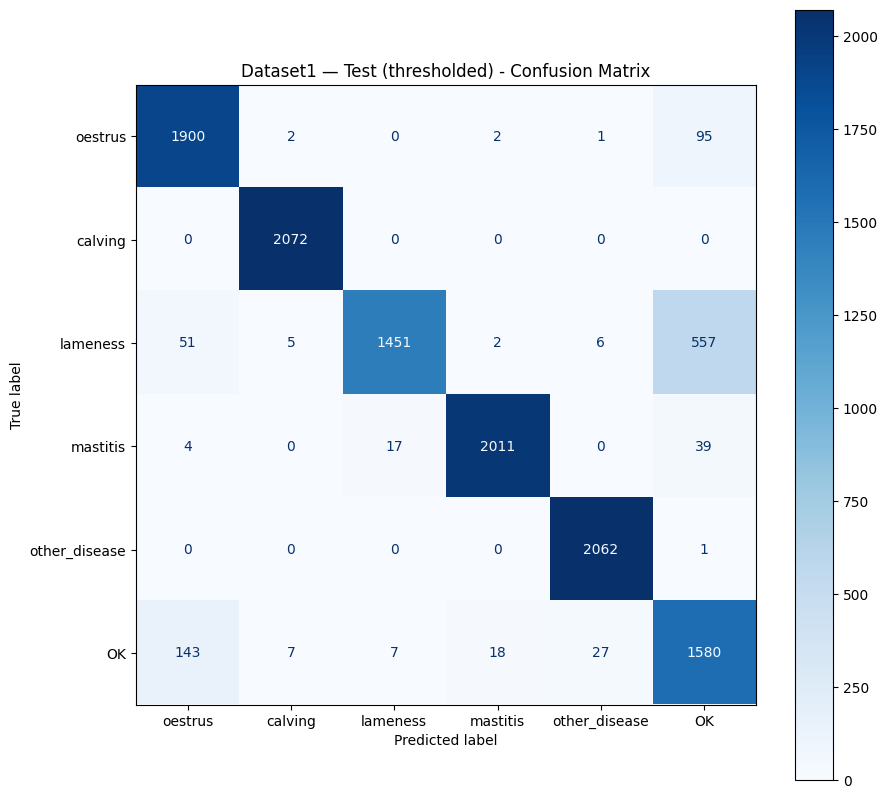

In [ ]:
# %% ======================= CELL 2: RUN (dataset-specific) =======================
from pathlib import Path

# -------- 1) Configure your dataset here --------
# Example for Dataset 1
TRAINVAL_CSV = Path("augmented_dataset1_trainval.csv")
TEST_CSV     = Path("augmented_dataset1_holdout.csv")  # optional for final test eval

# Customize your labels per dataset (order = class id)
LABEL_COLS   = ['oestrus', 'calving', 'lameness', 'mastitis', 'other_disease', 'OK']
DROP_COLS    = ['cow', 'duration_hours']  # columns to exclude from features
TARGET_COL   = 'target'
DATASET_NAME = "Dataset1"

# You can override any defaults here
CFG = dict(
    # model
    d_token=256, n_heads=8, n_layers=6,
    attn_dropout=0.15, ff_dropout=0.30, token_dropout=0.30,
    mlp_hidden=[512, 256, 128], mlp_dropout=0.35,
    # training
    batch_size=256, lr=3e-4, weight_decay=2e-3,
    epochs=300, early_stopping_patience=40,
    # misc
    seed=42, num_workers=0, grad_clip_norm=1.0,
    device="cuda" if torch.cuda.is_available() else "cpu",
)

# -------- 2) Load & prepare --------
df = pd.read_csv(TRAINVAL_CSV)

# Build integer target for this dataset (based on your LABEL_COLS order)
df = make_multiclass_target(df, LABEL_COLS, target_col=TARGET_COL)
y_int = df[TARGET_COL].values

# Group-aware split if 'cow' exists
tr_idx, va_idx = split_train_val(df, y_int, group_col='cow', train_size=0.8, seed=CFG.get("seed", 42))
df_train, df_val = df.iloc[tr_idx].copy(), df.iloc[va_idx].copy()

# Feature lists (you can also manually set cat_cols if you have integer-encoded categoricals)
cont_cols, cat_cols = build_feature_lists(df, LABEL_COLS, DROP_COLS, target_col=TARGET_COL)
num_classes = len(LABEL_COLS)

# -------- 3) Train --------
model, scaler, history = run_ft_transformer(
    df_train=df_train, df_val=df_val,
    cont_cols=cont_cols, cat_cols=cat_cols,
    label_col=TARGET_COL, num_classes=num_classes, cfg=CFG
)

# -------- 4) Plots (train vs val) --------
plot_history(history, title_prefix=f"FT-Transformer ({DATASET_NAME})")

# -------- 5) Validation threshold tuning (optional but recommended) --------
from torch.utils.data import DataLoader
val_ds = TabularDataset(df_val, cont_cols, cat_cols, label_col=TARGET_COL, scaler=scaler)
val_loader = DataLoader(val_ds, batch_size=CFG["batch_size"], shuffle=False, num_workers=CFG["num_workers"], pin_memory=True)

val_probs, val_true = collect_probs_and_true(model, val_loader, CFG["device"])
thresholds = find_opt_thresholds(val_probs, val_true, search=np.linspace(0.2, 0.9, 36))

val_preds, val_true_chk, _ = predict_with_thresholds(model, val_loader, thresholds, CFG["device"])
evaluate_with_cm(val_true_chk, val_preds, LABEL_COLS, title=f"{DATASET_NAME} — Validation (thresholded)")

# -------- 6) Test set evaluation (optional) --------
if TEST_CSV is not None and Path(TEST_CSV).exists():
    df_test = pd.read_csv(TEST_CSV)
    df_test = make_multiclass_target(df_test, LABEL_COLS, target_col=TARGET_COL)

    test_ds = TabularDataset(df_test, cont_cols, cat_cols, label_col=TARGET_COL, scaler=scaler)
    test_loader = DataLoader(test_ds, batch_size=CFG["batch_size"], shuffle=False,
                             num_workers=CFG["num_workers"], pin_memory=True)

    # Argmax
    with torch.no_grad():
        logits_all, y_all = [], []
        for x_cont, x_cat, y in test_loader:
            x_cont, x_cat = x_cont.to(CFG["device"]), x_cat.to(CFG["device"])
            logits_all.append(model(x_cont, x_cat).cpu()); y_all.append(y)
        logits = torch.cat(logits_all).numpy()
        y_true = torch.cat(y_all).numpy()
        y_pred_argmax = logits.argmax(1)
    evaluate_with_cm(y_true, y_pred_argmax, LABEL_COLS, title=f"{DATASET_NAME} — Test (argmax)")

    # Thresholded
    test_preds, test_true_chk, _ = predict_with_thresholds(model, test_loader, thresholds, CFG["device"])
    evaluate_with_cm(test_true_chk, test_preds, LABEL_COLS, title=f"{DATASET_NAME} — Test (thresholded)")


Epoch 001 | train_loss=1.1329 f1=0.4121 | val_loss=1.9094 f1=0.1383
Epoch 002 | train_loss=0.8580 f1=0.5202 | val_loss=2.1420 f1=0.1132
Epoch 003 | train_loss=0.7344 f1=0.5619 | val_loss=2.3439 f1=0.1095
Epoch 004 | train_loss=0.6472 f1=0.5896 | val_loss=2.4116 f1=0.1130
Epoch 005 | train_loss=0.5752 f1=0.6112 | val_loss=2.7149 f1=0.1041
Epoch 006 | train_loss=0.5253 f1=0.6254 | val_loss=2.9384 f1=0.0822
Epoch 007 | train_loss=0.4828 f1=0.6379 | val_loss=2.9227 f1=0.0853
Epoch 008 | train_loss=0.4440 f1=0.6497 | val_loss=3.1203 f1=0.0898
Epoch 009 | train_loss=0.4173 f1=0.6565 | val_loss=2.9720 f1=0.1049
Epoch 010 | train_loss=0.3897 f1=0.6629 | val_loss=3.1816 f1=0.1104
Epoch 011 | train_loss=0.3719 f1=0.6681 | val_loss=3.3336 f1=0.0957
Epoch 012 | train_loss=0.3549 f1=0.6728 | val_loss=3.2786 f1=0.0995
Epoch 013 | train_loss=0.3352 f1=0.6779 | val_loss=3.3187 f1=0.1215
Epoch 014 | train_loss=0.3252 f1=0.6801 | val_loss=3.7504 f1=0.1175
Epoch 015 | train_loss=0.3124 f1=0.6834 | val_lo

/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


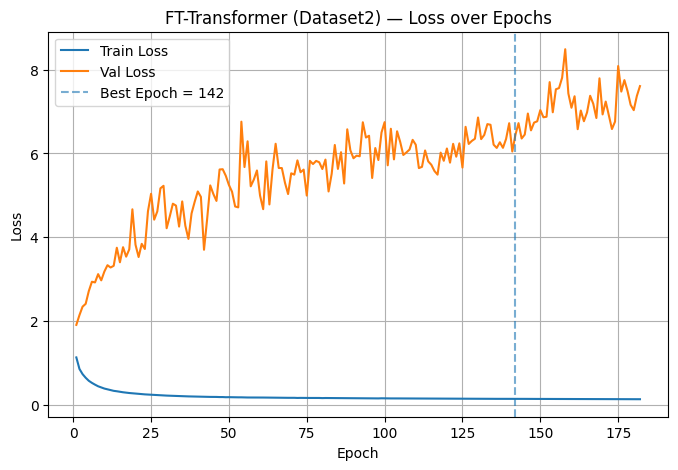

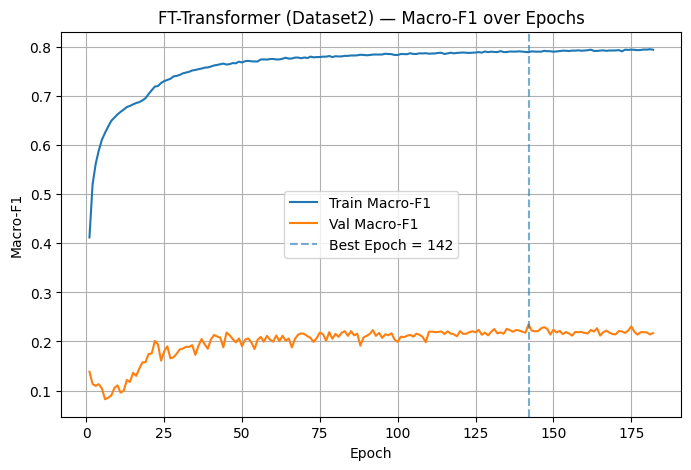


Dataset2 — Validation (thresholded):
               precision    recall  f1-score   support

      oestrus     0.7814    0.0666    0.1228     31058
     lameness     0.5173    0.5144    0.5159      7204
     mastitis     0.0000    0.0000    0.0000         0
other_disease     0.5651    0.2647    0.3605      5803
           OK     0.1096    0.9173    0.1958      4258

     accuracy                         0.2321     48323
    macro avg     0.3947    0.3526    0.2390     48323
 weighted avg     0.6569    0.2321    0.2164     48323

Macro F1: 0.2390   Weighted F1: 0.2164


/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


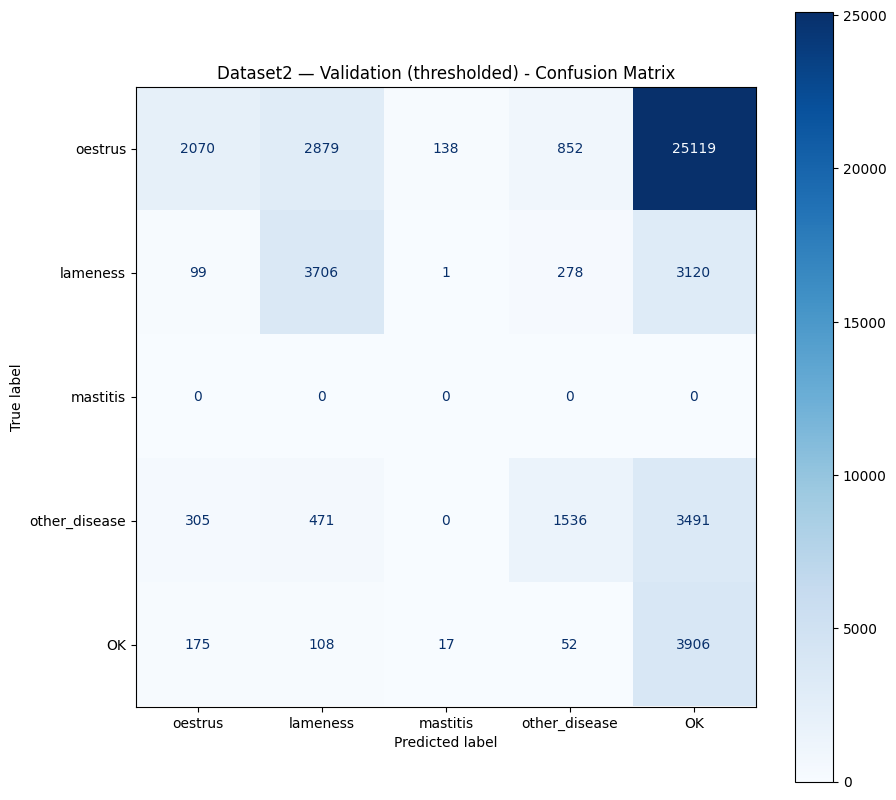


Dataset2 — Test (argmax):
               precision    recall  f1-score   support

      oestrus     0.9823    0.1783    0.3018     23080
     lameness     0.5917    0.8951    0.7124      3793
     mastitis     0.9020    1.0000    0.9485      3941
other_disease     0.7562    0.8724    0.8101      3886
           OK     0.1730    0.9784    0.2941      3421

     accuracy                         0.4771     38121
    macro avg     0.6811    0.7848    0.6134     38121
 weighted avg     0.8395    0.4771    0.4606     38121

Macro F1: 0.6134   Weighted F1: 0.4606


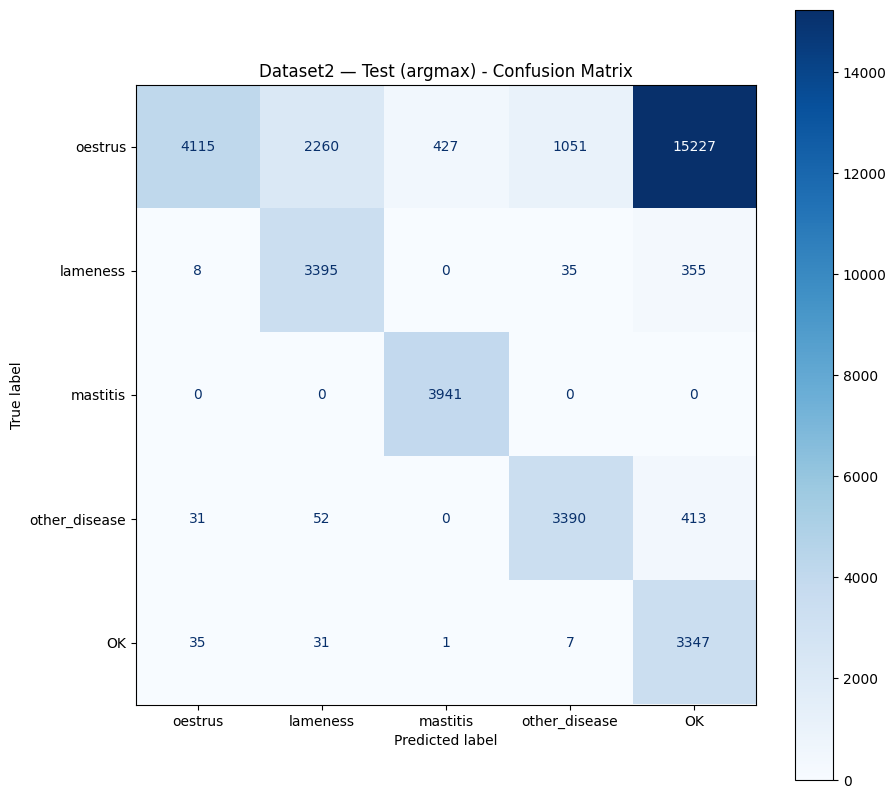


Dataset2 — Test (thresholded):
               precision    recall  f1-score   support

      oestrus     0.9773    0.1829    0.3082     23080
     lameness     0.5920    0.8951    0.7126      3793
     mastitis     0.9012    1.0000    0.9480      3941
other_disease     0.7547    0.8731    0.8096      3886
           OK     0.1733    0.9725    0.2942      3421

     accuracy                         0.4795     38121
    macro avg     0.6797    0.7847    0.6145     38121
 weighted avg     0.8363    0.4795    0.4644     38121

Macro F1: 0.6145   Weighted F1: 0.4644


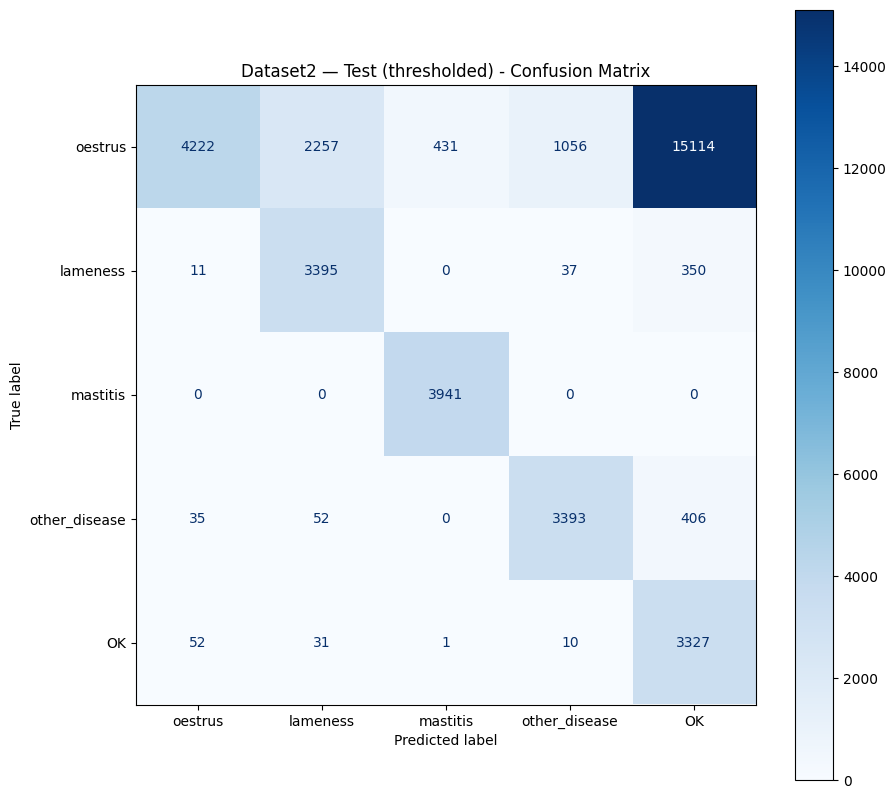

In [ ]:
# %% ======================= CELL 2: RUN (dataset-specific) =======================
from pathlib import Path

# -------- 1) Configure your dataset here --------
# Example for Dataset 1
TRAINVAL_CSV = Path("augmented_dataset2_trainval.csv")
TEST_CSV     = Path("augmented_dataset2_holdout.csv")

# Customize your labels per dataset (order = class id)
LABEL_COLS   = ['oestrus', 'lameness', 'mastitis', 'other_disease', 'OK']
DROP_COLS    = ['cow', 'duration_hours']  # columns to exclude from features
TARGET_COL   = 'target'
DATASET_NAME = "Dataset2"

# You can override any defaults here
CFG = dict(
    # model
    d_token=256, n_heads=8, n_layers=6,
    attn_dropout=0.15, ff_dropout=0.30, token_dropout=0.30,
    mlp_hidden=[512, 256, 128], mlp_dropout=0.35,
    # training
    batch_size=256, lr=3e-4, weight_decay=2e-3,
    epochs=300, early_stopping_patience=40,
    # misc
    seed=42, num_workers=0, grad_clip_norm=1.0,
    device="cuda" if torch.cuda.is_available() else "cpu",
)

# -------- 2) Load & prepare --------
df = pd.read_csv(TRAINVAL_CSV)

# Build integer target for this dataset (based on your LABEL_COLS order)
df = make_multiclass_target(df, LABEL_COLS, target_col=TARGET_COL)
y_int = df[TARGET_COL].values

# Group-aware split if 'cow' exists
tr_idx, va_idx = split_train_val(df, y_int, group_col='cow', train_size=0.8, seed=CFG.get("seed", 42))
df_train, df_val = df.iloc[tr_idx].copy(), df.iloc[va_idx].copy()

# Feature lists (you can also manually set cat_cols if you have integer-encoded categoricals)
cont_cols, cat_cols = build_feature_lists(df, LABEL_COLS, DROP_COLS, target_col=TARGET_COL)
num_classes = len(LABEL_COLS)

# -------- 3) Train --------
model, scaler, history = run_ft_transformer(
    df_train=df_train, df_val=df_val,
    cont_cols=cont_cols, cat_cols=cat_cols,
    label_col=TARGET_COL, num_classes=num_classes, cfg=CFG
)

# -------- 4) Plots (train vs val) --------
plot_history(history, title_prefix=f"FT-Transformer ({DATASET_NAME})")

# -------- 5) Validation threshold tuning (optional but recommended) --------
from torch.utils.data import DataLoader
val_ds = TabularDataset(df_val, cont_cols, cat_cols, label_col=TARGET_COL, scaler=scaler)
val_loader = DataLoader(val_ds, batch_size=CFG["batch_size"], shuffle=False, num_workers=CFG["num_workers"], pin_memory=True)

val_probs, val_true = collect_probs_and_true(model, val_loader, CFG["device"])
thresholds = find_opt_thresholds(val_probs, val_true, search=np.linspace(0.2, 0.9, 36))

val_preds, val_true_chk, _ = predict_with_thresholds(model, val_loader, thresholds, CFG["device"])
evaluate_with_cm(val_true_chk, val_preds, LABEL_COLS, title=f"{DATASET_NAME} — Validation (thresholded)")

# -------- 6) Test set evaluation (optional) --------
if TEST_CSV is not None and Path(TEST_CSV).exists():
    df_test = pd.read_csv(TEST_CSV)
    df_test = make_multiclass_target(df_test, LABEL_COLS, target_col=TARGET_COL)

    test_ds = TabularDataset(df_test, cont_cols, cat_cols, label_col=TARGET_COL, scaler=scaler)
    test_loader = DataLoader(test_ds, batch_size=CFG["batch_size"], shuffle=False,
                             num_workers=CFG["num_workers"], pin_memory=True)

    # Argmax
    with torch.no_grad():
        logits_all, y_all = [], []
        for x_cont, x_cat, y in test_loader:
            x_cont, x_cat = x_cont.to(CFG["device"]), x_cat.to(CFG["device"])
            logits_all.append(model(x_cont, x_cat).cpu()); y_all.append(y)
        logits = torch.cat(logits_all).numpy()
        y_true = torch.cat(y_all).numpy()
        y_pred_argmax = logits.argmax(1)
    evaluate_with_cm(y_true, y_pred_argmax, LABEL_COLS, title=f"{DATASET_NAME} — Test (argmax)")

    # Thresholded
    test_preds, test_true_chk, _ = predict_with_thresholds(model, test_loader, thresholds, CFG["device"])
    evaluate_with_cm(test_true_chk, test_preds, LABEL_COLS, title=f"{DATASET_NAME} — Test (thresholded)")


Epoch 001 | train_loss=0.7563 f1=0.5098 | val_loss=0.7023 f1=0.3514
Epoch 002 | train_loss=0.6977 f1=0.5307 | val_loss=0.6906 f1=0.4331
Epoch 003 | train_loss=0.6860 f1=0.5531 | val_loss=0.6932 f1=0.4312
Epoch 004 | train_loss=0.6804 f1=0.5572 | val_loss=0.6981 f1=0.4160
Epoch 005 | train_loss=0.6752 f1=0.5690 | val_loss=0.7052 f1=0.4318
Epoch 006 | train_loss=0.6690 f1=0.5810 | val_loss=0.7029 f1=0.4603
Epoch 007 | train_loss=0.6652 f1=0.5897 | val_loss=0.7200 f1=0.4452
Epoch 008 | train_loss=0.6541 f1=0.6094 | val_loss=0.7551 f1=0.4339
Epoch 009 | train_loss=0.6431 f1=0.6242 | val_loss=0.7391 f1=0.4767
Epoch 010 | train_loss=0.6203 f1=0.6529 | val_loss=0.7402 f1=0.4997
Epoch 011 | train_loss=0.5975 f1=0.6810 | val_loss=0.7772 f1=0.5281
Epoch 012 | train_loss=0.5772 f1=0.6980 | val_loss=0.7530 f1=0.5593
Epoch 013 | train_loss=0.5513 f1=0.7169 | val_loss=0.8029 f1=0.5695
Epoch 014 | train_loss=0.5389 f1=0.7266 | val_loss=0.9384 f1=0.5643
Epoch 015 | train_loss=0.5120 f1=0.7498 | val_lo

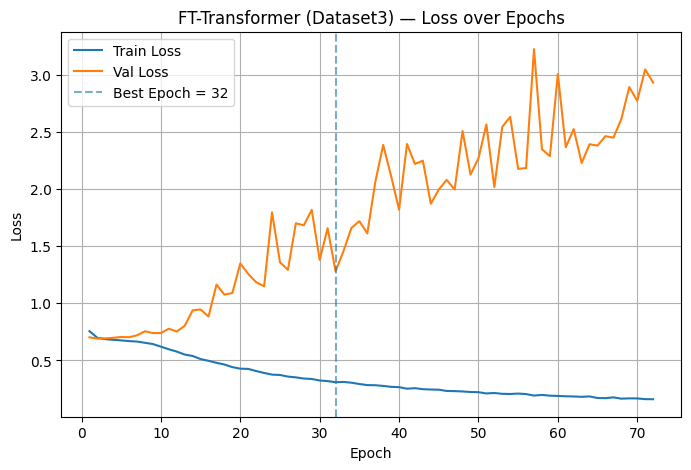

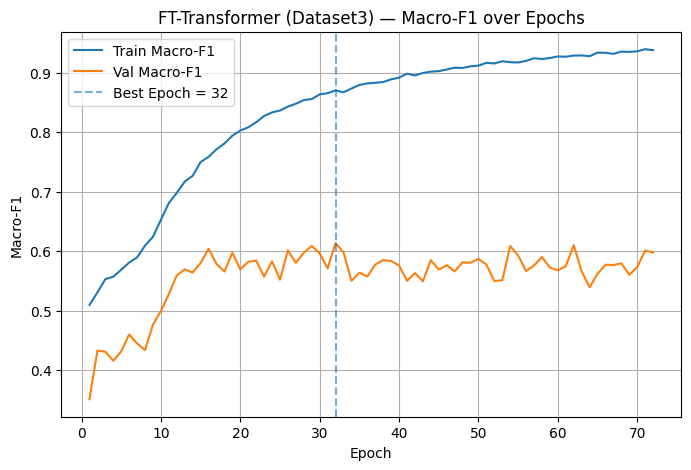


Dataset3 — Validation (thresholded):
              precision    recall  f1-score   support

     oestrus     0.6529    0.4485    0.5317      3233
          OK     0.6227    0.7924    0.6974      3714

    accuracy                         0.6324      6947
   macro avg     0.6378    0.6205    0.6146      6947
weighted avg     0.6367    0.6324    0.6203      6947

Macro F1: 0.6146   Weighted F1: 0.6203


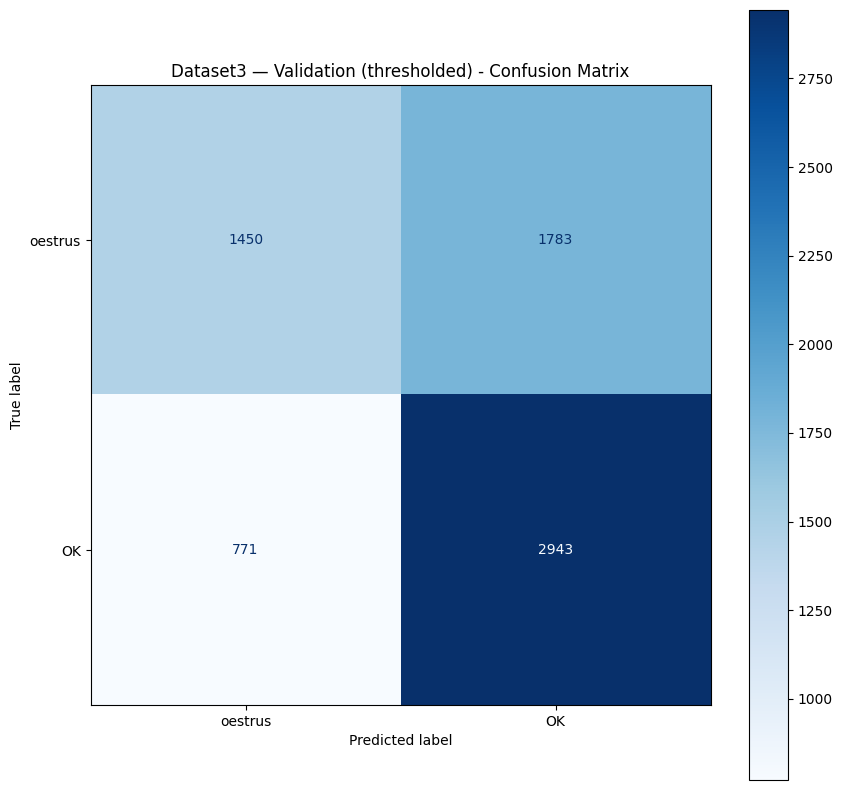


Dataset3 — Test (argmax):
              precision    recall  f1-score   support

     oestrus     0.9160    0.8936    0.9046      2293
          OK     0.8964    0.9183    0.9072      2300

    accuracy                         0.9059      4593
   macro avg     0.9062    0.9059    0.9059      4593
weighted avg     0.9062    0.9059    0.9059      4593

Macro F1: 0.9059   Weighted F1: 0.9059


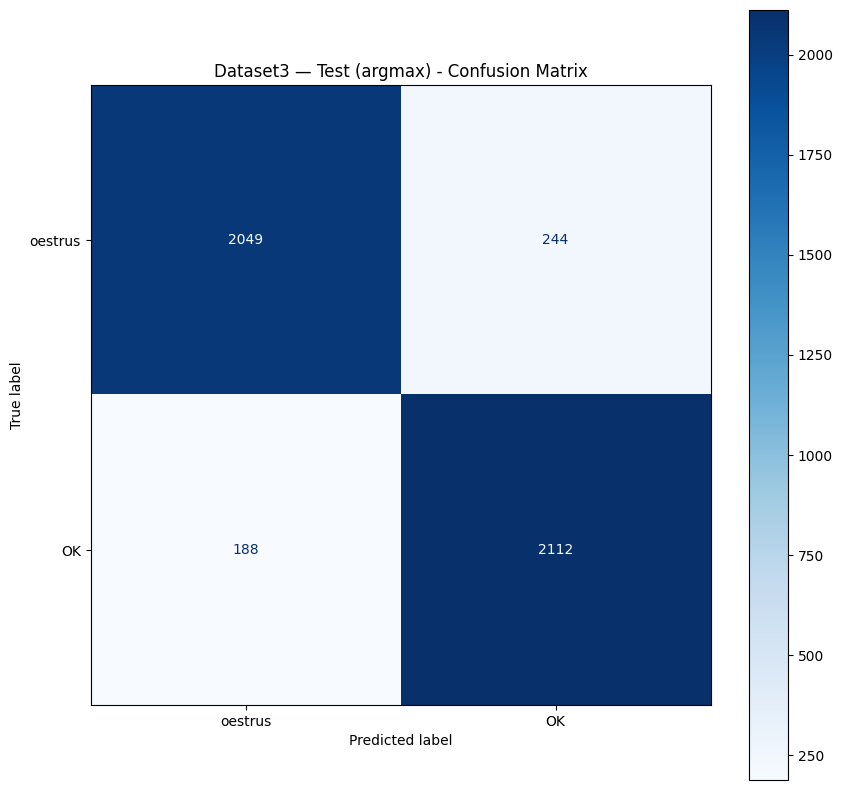


Dataset3 — Test (thresholded):
              precision    recall  f1-score   support

     oestrus     0.8860    0.9049    0.8954      2293
          OK     0.9032    0.8839    0.8934      2300

    accuracy                         0.8944      4593
   macro avg     0.8946    0.8944    0.8944      4593
weighted avg     0.8946    0.8944    0.8944      4593

Macro F1: 0.8944   Weighted F1: 0.8944


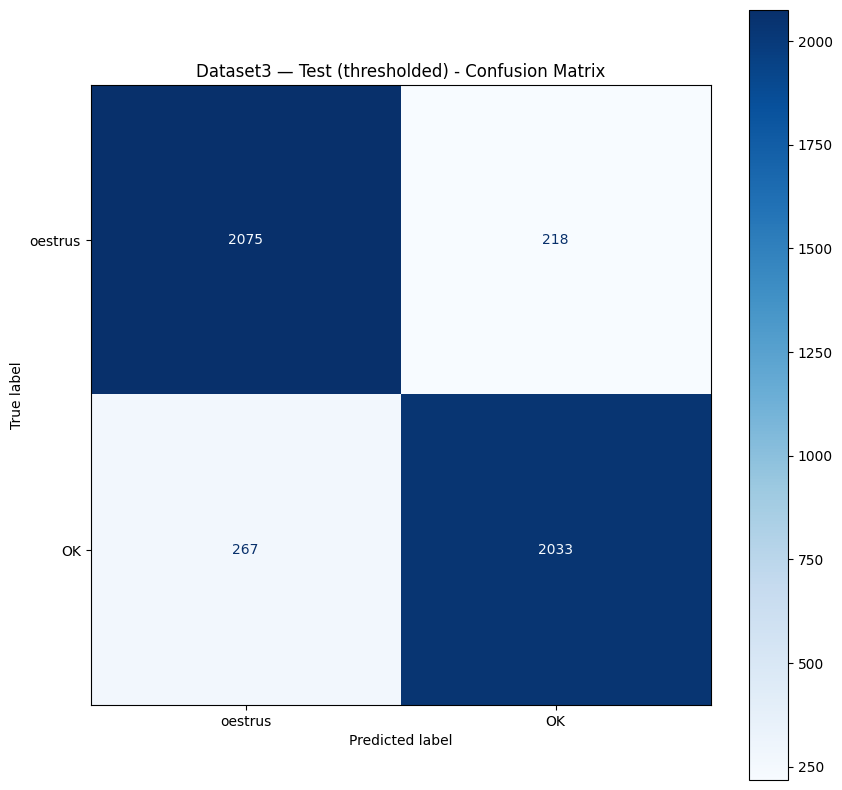

In [ ]:
# %% ======================= CELL 2: RUN (dataset-specific) =======================
from pathlib import Path

# -------- 1) Configure your dataset here --------
# Example for Dataset 1
TRAINVAL_CSV = Path("augmented_dataset3_trainval.csv")
TEST_CSV     = Path("augmented_dataset3_holdout.csv")

# Customize your labels per dataset (order = class id)
LABEL_COLS   = ['oestrus', 'OK']
DROP_COLS    = ['cow', 'duration_hours']  # columns to exclude from features
TARGET_COL   = 'target'
DATASET_NAME = "Dataset3"

# You can override any defaults here
CFG = dict(
    # model
    d_token=256, n_heads=8, n_layers=6,
    attn_dropout=0.15, ff_dropout=0.30, token_dropout=0.30,
    mlp_hidden=[512, 256, 128], mlp_dropout=0.35,
    # training
    batch_size=256, lr=3e-4, weight_decay=2e-3,
    epochs=300, early_stopping_patience=40,
    # misc
    seed=42, num_workers=0, grad_clip_norm=1.0,
    device="cuda" if torch.cuda.is_available() else "cpu",
)

# -------- 2) Load & prepare --------
df = pd.read_csv(TRAINVAL_CSV)

# Build integer target for this dataset (based on your LABEL_COLS order)
df = make_multiclass_target(df, LABEL_COLS, target_col=TARGET_COL)
y_int = df[TARGET_COL].values

# Group-aware split if 'cow' exists
tr_idx, va_idx = split_train_val(df, y_int, group_col='cow', train_size=0.8, seed=CFG.get("seed", 42))
df_train, df_val = df.iloc[tr_idx].copy(), df.iloc[va_idx].copy()

# Feature lists (you can also manually set cat_cols if you have integer-encoded categoricals)
cont_cols, cat_cols = build_feature_lists(df, LABEL_COLS, DROP_COLS, target_col=TARGET_COL)
num_classes = len(LABEL_COLS)

# -------- 3) Train --------
model, scaler, history = run_ft_transformer(
    df_train=df_train, df_val=df_val,
    cont_cols=cont_cols, cat_cols=cat_cols,
    label_col=TARGET_COL, num_classes=num_classes, cfg=CFG
)

# -------- 4) Plots (train vs val) --------
plot_history(history, title_prefix=f"FT-Transformer ({DATASET_NAME})")

# -------- 5) Validation threshold tuning (optional but recommended) --------
from torch.utils.data import DataLoader
val_ds = TabularDataset(df_val, cont_cols, cat_cols, label_col=TARGET_COL, scaler=scaler)
val_loader = DataLoader(val_ds, batch_size=CFG["batch_size"], shuffle=False, num_workers=CFG["num_workers"], pin_memory=True)

val_probs, val_true = collect_probs_and_true(model, val_loader, CFG["device"])
thresholds = find_opt_thresholds(val_probs, val_true, search=np.linspace(0.2, 0.9, 36))

val_preds, val_true_chk, _ = predict_with_thresholds(model, val_loader, thresholds, CFG["device"])
evaluate_with_cm(val_true_chk, val_preds, LABEL_COLS, title=f"{DATASET_NAME} — Validation (thresholded)")

# -------- 6) Test set evaluation (optional) --------
if TEST_CSV is not None and Path(TEST_CSV).exists():
    df_test = pd.read_csv(TEST_CSV)
    df_test = make_multiclass_target(df_test, LABEL_COLS, target_col=TARGET_COL)

    test_ds = TabularDataset(df_test, cont_cols, cat_cols, label_col=TARGET_COL, scaler=scaler)
    test_loader = DataLoader(test_ds, batch_size=CFG["batch_size"], shuffle=False,
                             num_workers=CFG["num_workers"], pin_memory=True)

    # Argmax
    with torch.no_grad():
        logits_all, y_all = [], []
        for x_cont, x_cat, y in test_loader:
            x_cont, x_cat = x_cont.to(CFG["device"]), x_cat.to(CFG["device"])
            logits_all.append(model(x_cont, x_cat).cpu()); y_all.append(y)
        logits = torch.cat(logits_all).numpy()
        y_true = torch.cat(y_all).numpy()
        y_pred_argmax = logits.argmax(1)
    evaluate_with_cm(y_true, y_pred_argmax, LABEL_COLS, title=f"{DATASET_NAME} — Test (argmax)")

    # Thresholded
    test_preds, test_true_chk, _ = predict_with_thresholds(model, test_loader, thresholds, CFG["device"])
    evaluate_with_cm(test_true_chk, test_preds, LABEL_COLS, title=f"{DATASET_NAME} — Test (thresholded)")


Epoch 001 | train_loss=1.6177 f1=0.2987 | val_loss=1.4647 f1=0.3001
Epoch 002 | train_loss=1.4132 f1=0.4130 | val_loss=1.4740 f1=0.3081
Epoch 003 | train_loss=1.2798 f1=0.4819 | val_loss=1.4221 f1=0.3410
Epoch 004 | train_loss=1.1565 f1=0.5409 | val_loss=1.4160 f1=0.3411
Epoch 005 | train_loss=1.0624 f1=0.5797 | val_loss=1.3922 f1=0.3545
Epoch 006 | train_loss=0.9818 f1=0.6122 | val_loss=1.6522 f1=0.3228
Epoch 007 | train_loss=0.9132 f1=0.6392 | val_loss=1.6607 f1=0.3356
Epoch 008 | train_loss=0.8345 f1=0.6702 | val_loss=1.6978 f1=0.3535
Epoch 009 | train_loss=0.7813 f1=0.6908 | val_loss=1.6829 f1=0.3614
Epoch 010 | train_loss=0.7299 f1=0.7119 | val_loss=2.0010 f1=0.3543
Epoch 011 | train_loss=0.6760 f1=0.7369 | val_loss=2.2202 f1=0.3388
Epoch 012 | train_loss=0.6234 f1=0.7594 | val_loss=2.3527 f1=0.3588
Epoch 013 | train_loss=0.5825 f1=0.7770 | val_loss=2.1937 f1=0.3707
Epoch 014 | train_loss=0.5478 f1=0.7941 | val_loss=2.3385 f1=0.3757
Epoch 015 | train_loss=0.5164 f1=0.8061 | val_lo

/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


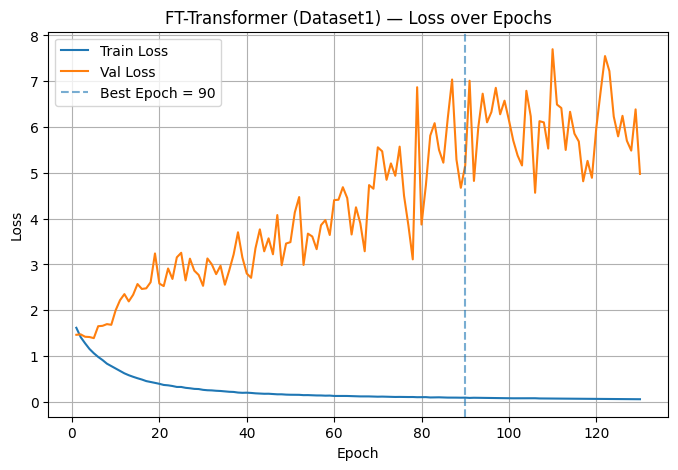

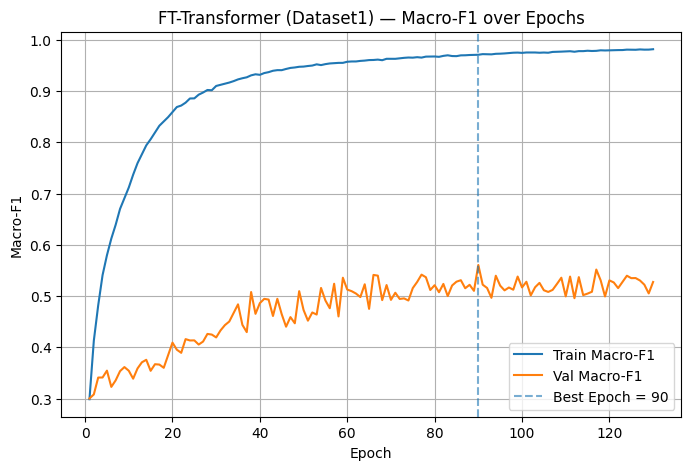


Dataset1 — Validation (thresholded):
               precision    recall  f1-score   support

      oestrus     0.5827    1.0000    0.7363       148
      calving     0.8353    0.9297    0.8800      2733
     lameness     0.9266    0.5221    0.6679      4185
     mastitis     0.0000    0.0000    0.0000         0
other_disease     0.9479    0.3878    0.5504      3566
           OK     0.4272    0.8721    0.5735      3363

     accuracy                         0.6567     13995
    macro avg     0.6200    0.6186    0.5680     13995
 weighted avg     0.7906    0.6567    0.6574     13995

Macro F1: 0.5680   Weighted F1: 0.6574


/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


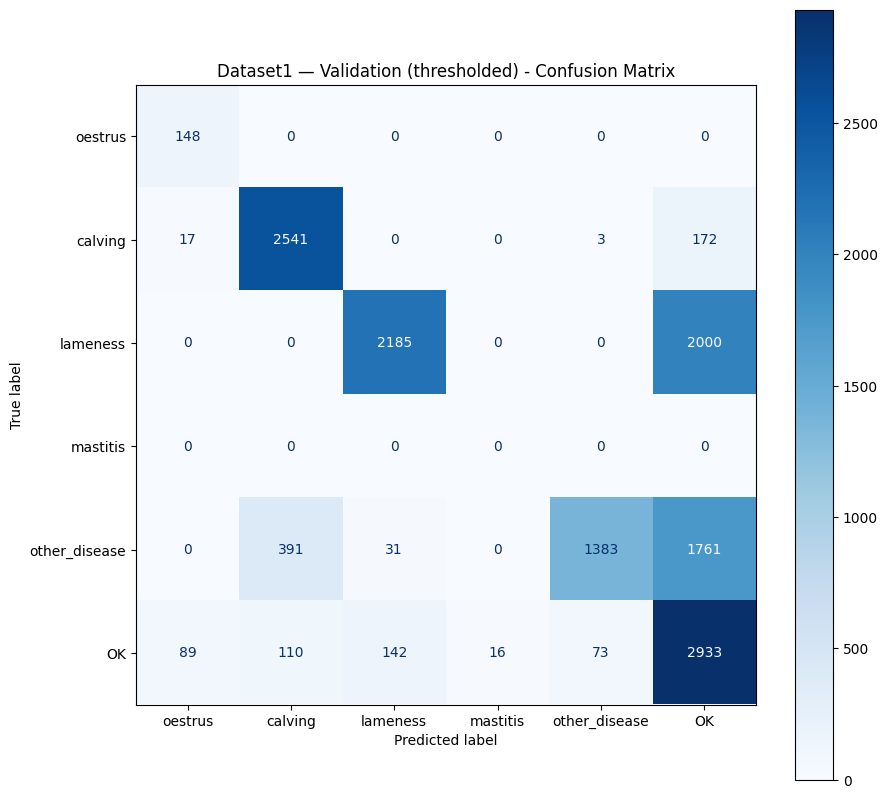


Dataset1 — Test (argmax):
               precision    recall  f1-score   support

      oestrus     0.9736    0.9937    0.9836      1745
      calving     0.9622    0.9890    0.9754      1726
     lameness     0.9684    0.8593    0.9106      1748
     mastitis     0.9971    1.0000    0.9986      1743
other_disease     0.9876    0.8637    0.9215      1754
           OK     0.7702    0.9151    0.8364      1743

     accuracy                         0.9366     10459
    macro avg     0.9432    0.9368    0.9377     10459
 weighted avg     0.9432    0.9366    0.9376     10459

Macro F1: 0.9377   Weighted F1: 0.9376


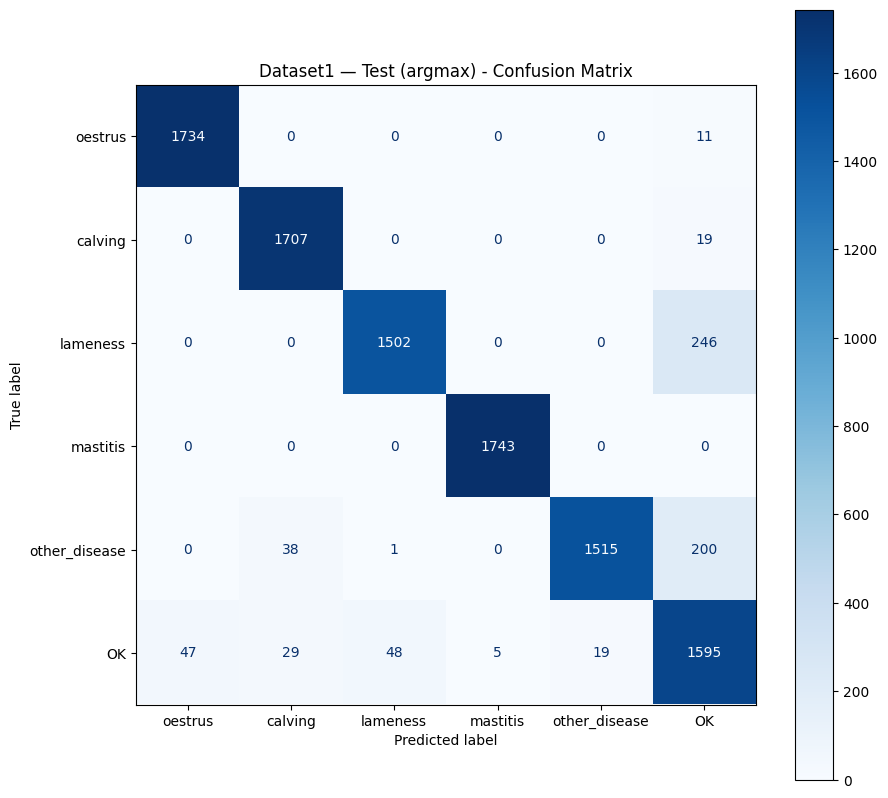


Dataset1 — Test (thresholded):
               precision    recall  f1-score   support

      oestrus     0.9736    0.9931    0.9833      1745
      calving     0.9628    0.9890    0.9757      1726
     lameness     0.9619    0.8667    0.9118      1748
     mastitis     0.9971    1.0000    0.9986      1743
other_disease     0.9852    0.8706    0.9243      1754
           OK     0.7782    0.9076    0.8379      1743

     accuracy                         0.9377     10459
    macro avg     0.9431    0.9378    0.9386     10459
 weighted avg     0.9431    0.9377    0.9385     10459

Macro F1: 0.9386   Weighted F1: 0.9385


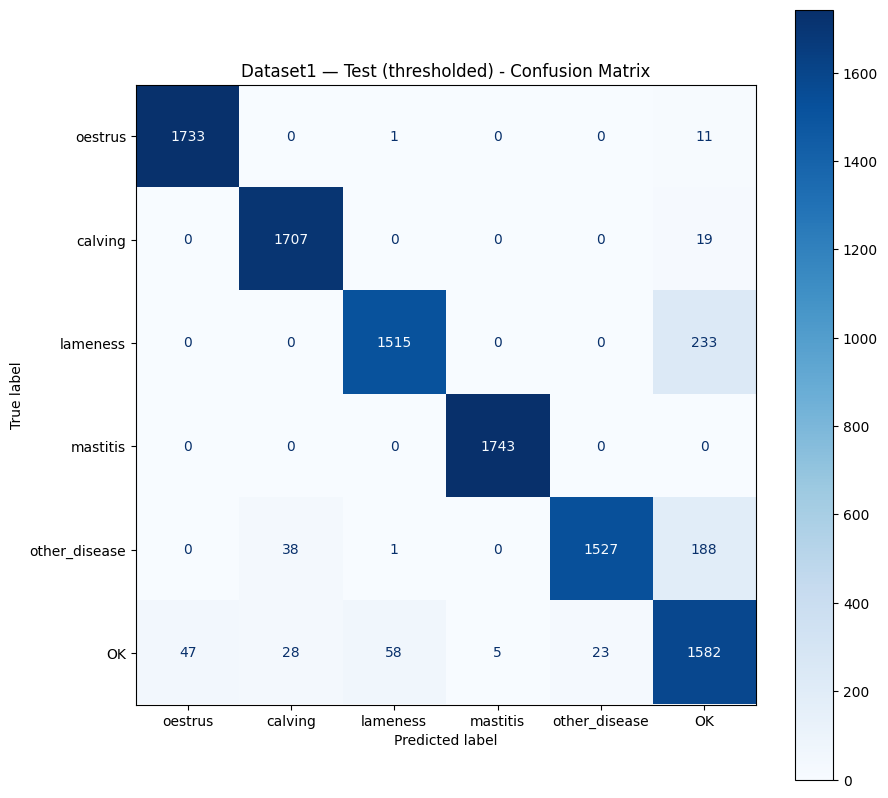

In [ ]:
# %% ======================= CELL 2: RUN (dataset-specific) =======================
from pathlib import Path

# -------- 1) Configure your dataset here --------
# Example for Dataset 1
TRAINVAL_CSV = Path("augmented_dataset4_trainval.csv")
TEST_CSV     = Path("augmented_dataset4_holdout.csv")

# Customize your labels per dataset (order = class id)
LABEL_COLS   = ['oestrus', 'calving', 'lameness', 'mastitis', 'other_disease', 'OK']
DROP_COLS    = ['cow', 'duration_hours']  # columns to exclude from features
TARGET_COL   = 'target'
DATASET_NAME = "Dataset1"

# You can override any defaults here
CFG = dict(
    # model
    d_token=256, n_heads=8, n_layers=6,
    attn_dropout=0.15, ff_dropout=0.30, token_dropout=0.30,
    mlp_hidden=[512, 256, 128], mlp_dropout=0.35,
    # training
    batch_size=256, lr=3e-4, weight_decay=2e-3,
    epochs=300, early_stopping_patience=40,
    # misc
    seed=42, num_workers=0, grad_clip_norm=1.0,
    device="cuda" if torch.cuda.is_available() else "cpu",
)

# -------- 2) Load & prepare --------
df = pd.read_csv(TRAINVAL_CSV)

# Build integer target for this dataset (based on your LABEL_COLS order)
df = make_multiclass_target(df, LABEL_COLS, target_col=TARGET_COL)
y_int = df[TARGET_COL].values

# Group-aware split if 'cow' exists
tr_idx, va_idx = split_train_val(df, y_int, group_col='cow', train_size=0.8, seed=CFG.get("seed", 42))
df_train, df_val = df.iloc[tr_idx].copy(), df.iloc[va_idx].copy()

# Feature lists (you can also manually set cat_cols if you have integer-encoded categoricals)
cont_cols, cat_cols = build_feature_lists(df, LABEL_COLS, DROP_COLS, target_col=TARGET_COL)
num_classes = len(LABEL_COLS)

# -------- 3) Train --------
model, scaler, history = run_ft_transformer(
    df_train=df_train, df_val=df_val,
    cont_cols=cont_cols, cat_cols=cat_cols,
    label_col=TARGET_COL, num_classes=num_classes, cfg=CFG
)

# -------- 4) Plots (train vs val) --------
plot_history(history, title_prefix=f"FT-Transformer ({DATASET_NAME})")

# -------- 5) Validation threshold tuning (optional but recommended) --------
from torch.utils.data import DataLoader
val_ds = TabularDataset(df_val, cont_cols, cat_cols, label_col=TARGET_COL, scaler=scaler)
val_loader = DataLoader(val_ds, batch_size=CFG["batch_size"], shuffle=False, num_workers=CFG["num_workers"], pin_memory=True)

val_probs, val_true = collect_probs_and_true(model, val_loader, CFG["device"])
thresholds = find_opt_thresholds(val_probs, val_true, search=np.linspace(0.2, 0.9, 36))

val_preds, val_true_chk, _ = predict_with_thresholds(model, val_loader, thresholds, CFG["device"])
evaluate_with_cm(val_true_chk, val_preds, LABEL_COLS, title=f"{DATASET_NAME} — Validation (thresholded)")

# -------- 6) Test set evaluation (optional) --------
if TEST_CSV is not None and Path(TEST_CSV).exists():
    df_test = pd.read_csv(TEST_CSV)
    df_test = make_multiclass_target(df_test, LABEL_COLS, target_col=TARGET_COL)

    test_ds = TabularDataset(df_test, cont_cols, cat_cols, label_col=TARGET_COL, scaler=scaler)
    test_loader = DataLoader(test_ds, batch_size=CFG["batch_size"], shuffle=False,
                             num_workers=CFG["num_workers"], pin_memory=True)

    # Argmax
    with torch.no_grad():
        logits_all, y_all = [], []
        for x_cont, x_cat, y in test_loader:
            x_cont, x_cat = x_cont.to(CFG["device"]), x_cat.to(CFG["device"])
            logits_all.append(model(x_cont, x_cat).cpu()); y_all.append(y)
        logits = torch.cat(logits_all).numpy()
        y_true = torch.cat(y_all).numpy()
        y_pred_argmax = logits.argmax(1)
    evaluate_with_cm(y_true, y_pred_argmax, LABEL_COLS, title=f"{DATASET_NAME} — Test (argmax)")

    # Thresholded
    test_preds, test_true_chk, _ = predict_with_thresholds(model, test_loader, thresholds, CFG["device"])
    evaluate_with_cm(test_true_chk, test_preds, LABEL_COLS, title=f"{DATASET_NAME} — Test (thresholded)")
